In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'times'
plt.rcParams['axes.axisbelow'] = True
from scipy.stats import spearmanr, kendalltau

In [3]:
def strtofloat(x):

    if ',' not in str(x):
        return float(x)
    else :
        a, b = x.split(',')
        return float(a) + float(b) / 10

### Create a csv with all teams and conferences since 2014

In [4]:
import time

years = np.arange(2014, 2024)
dfs = []
for year in years :

    url = f'https://www.basketball-reference.com/leagues/NBA_{year}_standings.html'
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'lxml')
    while soup.find(class_ = 'thead') is not None:
        soup.find(class_ = 'thead').decompose()
    east_table, west_table = [t for t in soup.find_all('table') if 'divs_standings' in t.get('id')]

    for table, name in zip([east_table, west_table], ['East', 'West']) :
        df = pd.read_html(str(table))[0].rename(columns = {f'{name}ern Conference': 'Team'})
        df['Tm'] = [str(x).split('/')[2] for x in table.find_all('a', href = True)]
        df['Year'] = len(df) * [year]
        df['Conference'] = len(df) * [name]
        dfs.append(df[['Tm', 'Year', 'Conference']])
    time.sleep(5)

KeyboardInterrupt: 

In [7]:
confs = pd.concat(dfs)
confs.to_csv('data/conferences_2014-2023.csv', index = None)

### Create the baseline prediction

In [10]:
standings = pd.read_csv('data/Standings_1979-2023.csv')
standings = standings[standings['Year'] >= 2014 - 1]
#standings['Year'] = standings['Year'] + 1 # Add one year to predict last year's total wins
standings = standings[['Year', 'Tm', 'W']].rename(columns = {'W': 'Real'})

In [200]:
pred = standings.copy()[standings['Year'] < 2023].rename(columns = {'Real': 'Pred'})
pred['Year'] = pred['Year'] + 1 # Add one year to predict last year's total wins

In [206]:
pred_df = pred.merge(standings, on = ['Year', 'Tm'], how = 'left')
pred_df.to_csv('data/pred_test_baseline.csv', index = False)

### Function to evaluate models

In [40]:
def evaluate_model(path, years) :

    res = pd.read_csv(path)
    res.dropna(inplace = True)
    res['Real'] = round(res['Real'])
    confs = pd.read_csv('data/conferences_2014-2023.csv')
    res = res.merge(confs, on = ['Year', 'Tm'], how = 'left')
    avg = [r2_score(res['Real'], res['Pred']), np.abs(res['Pred'] - res['Real']).mean()]#, np.sqrt((res['Pred'] - res['Real']) ** 2).mean()]

    metrics = np.zeros((len(years), 7))
    for i, year in enumerate(years) :
        res_yr = res.copy().groupby('Year').get_group(year)
        mae = np.abs(res_yr['Pred'] - res_yr['Real']).mean()
        r2 = r2_score(res_yr['Real'], res_yr['Pred'])
        rmse = np.sqrt((res_yr['Pred'] - res_yr['Real']) ** 2).mean()

        spmr, _ = spearmanr(res_yr['Real'], res_yr['Pred'])
        ktau, _ = kendalltau(res_yr['Real'], res_yr['Pred'])

        res_yr_east = res_yr.copy()[res_yr['Conference'] == 'East']
        res_yr_west = res_yr.copy()[res_yr['Conference'] == 'West']

        res_yr['Rank'] = res_yr['Real'].rank(ascending = False, method = 'min')
        res_yr['PredRank'] = res_yr['Pred'].rank(ascending = False, method = 'min')
        
        res_yr_east['Rank'] = res_yr_east['Real'].rank(ascending = False, method = 'min')
        res_yr_east['PredRank'] = res_yr_east['Pred'].rank(ascending = False, method = 'min')

        res_yr_west['Rank'] = res_yr_west['Real'].rank(ascending = False, method = 'min')
        res_yr_west['PredRank'] = res_yr_west['Pred'].rank(ascending = False, method = 'min')

        rank_mae_east = np.abs(res_yr_east['PredRank'] - res_yr_east['Rank']).mean()
        rank_mae_west = np.abs(res_yr_west['PredRank'] - res_yr_west['Rank']).mean()
        rank_mae = np.abs(res_yr['PredRank'] - res_yr['Rank']).mean()

        metrics[i, :] = np.array([r2, mae, spmr, ktau, rank_mae_east, rank_mae_west, rank_mae])
    avg = avg + metrics[:,3:].mean(axis = 0).tolist()

    return metrics, np.array(avg)

In [41]:
years = np.arange(2015, 2024)

In [42]:
res_lr, avg_lr = evaluate_model('data/pred_test_LR.csv', years)
res_rf, avg_rf = evaluate_model('data/pred_test_RF.csv', years)
res_xgb, avg_xgb = evaluate_model('data/pred_test_XGB.csv', years)
res_cart, avg_cart = evaluate_model('data/pred_test_CART.csv', years)
res_nn, avg_nn = evaluate_model('data/pred_test_NN.csv', years)
res_baseline, avg_baseline = evaluate_model('data/pred_test_baseline.csv', years)
res_espn, avg_espn = evaluate_model('data/espn.csv', years)

In [34]:
metrics = pd.DataFrame(np.column_stack((avg_lr, avg_rf, avg_xgb, avg_cart, avg_nn, avg_baseline, avg_espn)).T,
            columns = ['R2', 'MAE', 'SpearmanR', 'KendallTau', 'MAE_east', 'MAE_west'],
            index = ['Linear Reg.', 'RF', 'XGBoost', 'CART', 'NeuralNet', 'Baseline', 'ESPN'])
metrics['porder'] = 5 * [2] + [0] + [1]
metrics = metrics.sort_values(['porder', 'R2'], ascending = False)
metrics

ValueError: Shape of passed values is (7, 5), indices imply (7, 6)

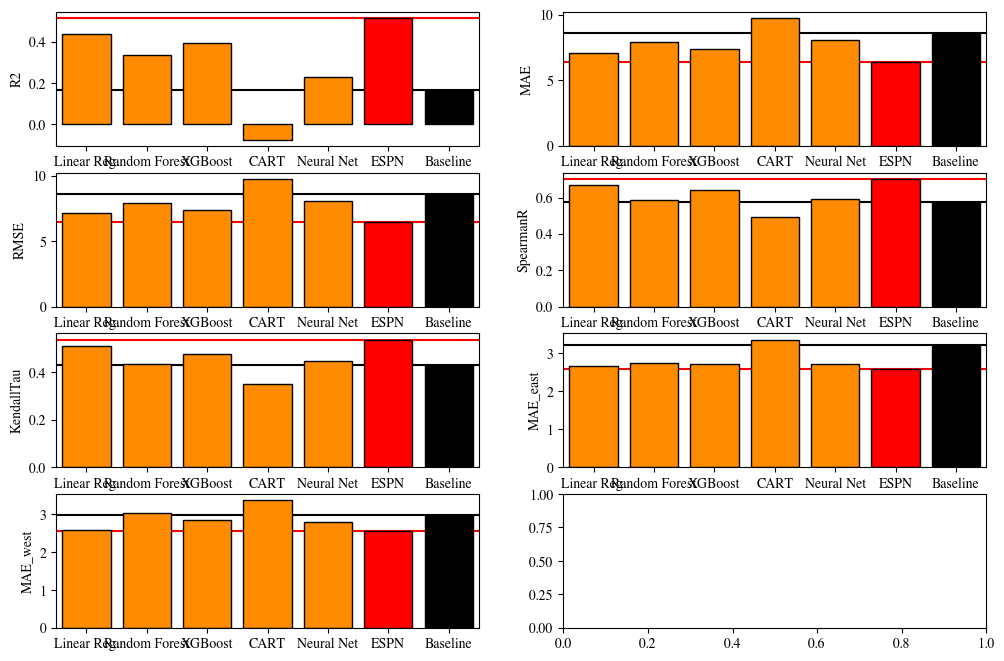

In [275]:
fig, axs = plt.subplots(4, 2, figsize = (12, 8)); axs = axs.flatten()
for i, metric in enumerate(metrics.columns[:7]) :
    axs[i].bar(metrics.index, metrics[metric], color = metrics['colors'], edgecolor = 'k')
    axs[i].plot([-10, 17], 2 * [metrics.loc['Baseline'][metric]], c = 'k', zorder = -1)
    axs[i].plot([-10, 17], 2 * [metrics.loc['ESPN'][metric]], c = 'r', zorder = -1)
    axs[i].set_xlim([-0.5, 6.5])
    axs[i].set_ylabel(metric)

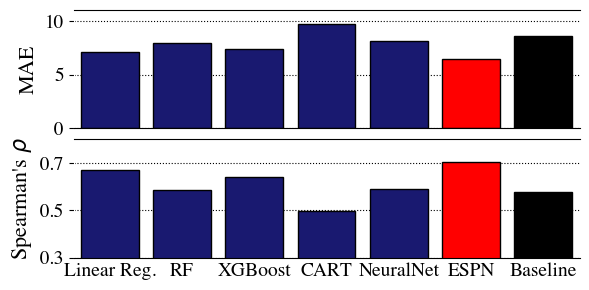

In [326]:
fig, axs = plt.subplots(2, 1, figsize = (6, 3))
axs[0].bar(metrics.index, metrics['MAE'], color = metrics['colors'], edgecolor = 'k')
axs[0].set_xlim([-0.5, 6.5])
axs[0].set_ylim([0, 11])
axs[0].set_yticks([0, 5, 10], [0, 5, 10])
axs[0].set_ylabel('MAE', size = 16)
axs[0].grid(axis = 'y', linestyle = ':', color = 'k')
axs[0].set_xticks([])
axs[0].tick_params(labelsize = 14, axis = 'both')

axs[1].bar(metrics.index, metrics['SpearmanR'], color = metrics['colors'], edgecolor = 'k')
axs[1].set_xlim([-0.5, 6.5])
axs[1].set_ylim([0.3, 0.8])
axs[1].set_yticks([0.3, 0.5, 0.7], [0.3, 0.5, 0.7])
axs[1].set_ylabel(r"Spearman's $\rho$", size = 16)
axs[1].grid(axis = 'y', linestyle = ':', color = 'k')
axs[1].tick_params(labelsize = 14, axis = 'both')

axs[0].spines['left'].set_color('w')
axs[0].spines['right'].set_color('w')
axs[1].spines['left'].set_color('w')
axs[1].spines['right'].set_color('w')

axs[1].tick_params(axis = 'x', size = 0)

plt.tight_layout(h_pad = 0)
plt.savefig('figures/mae_spearmanrho_models.jpeg', dpi = 400)
plt.show()

In [69]:
stoch = pd.read_csv('data/pred_test_stoch.csv')
def metrics(df) :
    spr, _ = spearmanr(df['Real'], df['Pred'])
    return spr
spr = stoch.groupby('Year').apply(metrics)
spr.values

array([0.67225459, 0.6444122 , 0.81031989, 0.38119143, 0.58804647,
       0.79204921])

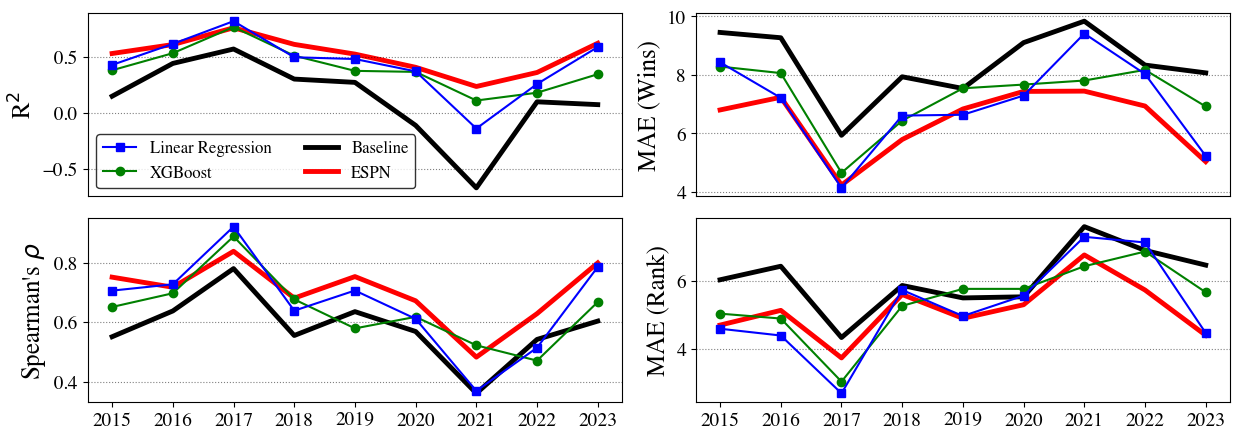

In [143]:
fig, axs = plt.subplots(2, 2, figsize = (12.5, 4.5)); axs = axs.flatten()

for ax, ttl, j in zip(axs, [r'R$^2$', 'MAE (Wins)', r"Spearman's $\rho$", 'MAE (Rank)'], [0, 1, 2, -1]) :
    ax.plot(years, res_lr[:,j], 's-', label = 'Linear Regression', color = 'blue', zorder = 1)
    ax.plot(years, res_xgb[:,j], 'o-', label = 'XGBoost', color = 'green', zorder = 0.9)
    ax.plot(years, res_baseline[:,j], 'k-', label = 'Baseline', zorder = -1, linewidth = 3.5)
    ax.plot(years, res_espn[:,j], 'r-', label = 'ESPN', zorder = 0, linewidth = 3.5)
    ax.set_ylabel(ttl, size = 18)
    ax.grid(axis = 'y', alpha = 0.5, c = 'k', linestyle = ':')
    ax.tick_params(axis = 'both', labelsize = 14)
#axs[2].plot(spr.index, spr.values)
axs[0].set_xticks([]); axs[1].set_xticks([])
axs[0].legend(ncols = 2, fontsize = 12, loc = 'lower left', edgecolor = 'k')
plt.tight_layout()
plt.savefig('figures/metrics_times-series.jpeg', dpi = 500)
plt.show()

In [72]:
spr.values.mean()

0.6480456330340323

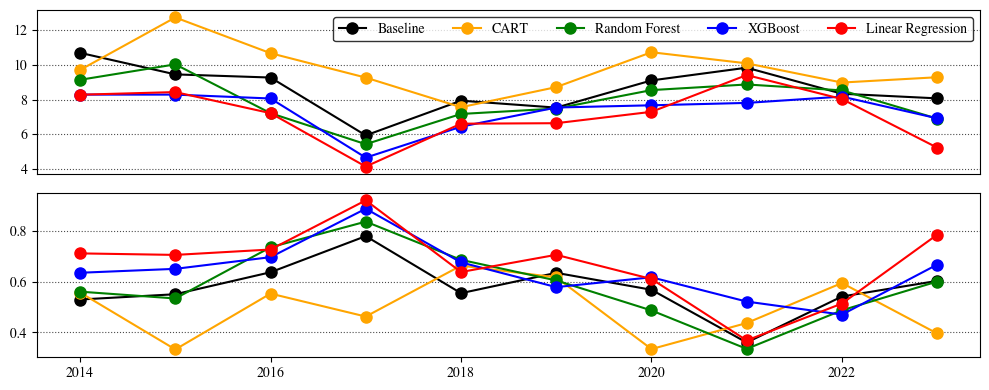

In [76]:
fig, axs = plt.subplots(2, 1, figsize = (10, 4))


axs[0].plot(years, res_baseline[:,1], c = 'k', marker = 'o', markersize = 8, label = 'Baseline')
axs[0].plot(years, res_cart[:,1], c = 'orange', marker = 'o', markersize = 8, label = 'CART')
axs[0].plot(years, res_rf[:,1], c = 'g', marker = 'o', markersize = 8, label = 'Random Forest')
axs[0].plot(years, res_xgb[:,1], c = 'b', marker = 'o', markersize = 8, label = 'XGBoost')
axs[0].plot(years, res_lr[:,1], c = 'r', marker = 'o', markersize = 8, label = 'Linear Regression')
axs[0].grid(axis = 'y', linestyle = ':', alpha = 0.7, color = 'k')
axs[0].set_xticks([])

axs[1].plot(years, res_baseline[:,2], c = 'k', marker = 'o', markersize = 8, label = 'Baseline')
axs[1].plot(years, res_cart[:,2], c = 'orange', marker = 'o', markersize = 8, label = 'CART')
axs[1].plot(years, res_rf[:,2], c = 'g', marker = 'o', markersize = 8, label = 'Random Forest')
axs[1].plot(years, res_xgb[:,2], c = 'b', marker = 'o', markersize = 8, label = 'XGBoost')
axs[1].plot(years, res_lr[:,2], c = 'r', marker = 'o', markersize = 8, label = 'Linear Regression')
axs[1].grid(axis = 'y', linestyle = ':', alpha = 0.7, color = 'k')

axs[0].legend(ncols = 5, edgecolor = 'k')
plt.tight_layout()
plt.show()

In [295]:
pct_lr = 100 * (res_lr - res_baseline) / np.abs(res_baseline)
pct_rf = 100 * (res_rf - res_baseline) / np.abs(res_baseline)
pct_xgb = 100 * (res_xgb - res_baseline) / np.abs(res_baseline)

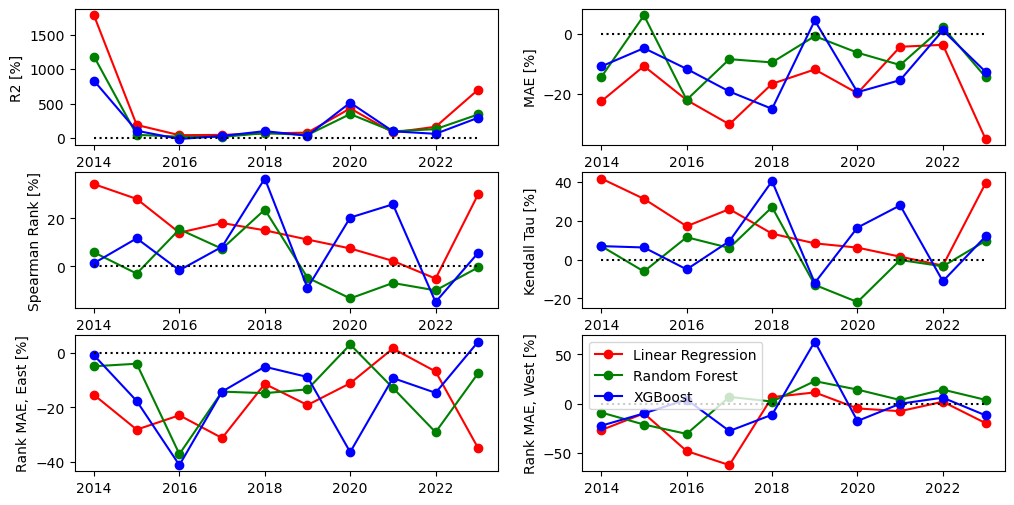

In [296]:
fig, axs = plt.subplots(3, 2, figsize = (12, 6)); axs = axs.flatten()

for j, (ax, ttl) in enumerate(zip(axs, ['R2', 'MAE', 'Spearman Rank', 'Kendall Tau', 'Rank MAE, East', 'Rank MAE, West'])) :
    ax.plot(years, pct_lr[:,j], 'r-o', label = 'Linear Regression')
    ax.plot(years, pct_rf[:,j], 'g-o', label = 'Random Forest')
    ax.plot(years, pct_xgb[:,j], 'b-o', label = 'XGBoost')
    ax.plot(years, [0.0] * len(years), 'k:')
    ax.set_ylabel(f'{ttl} [%]')

plt.legend()
plt.show()

## ESPN

In [22]:
espn = pd.read_csv("data/espn.csv", delimiter=";")

In [21]:
only2023 = standings[(standings.Year == 2023)].drop("Year", axis = 1).merge(espn, how = "left", on = "Tm")

In [20]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(only2023.Real, only2023.Pred))
print(r2_score(only2023.Real, only2023.Pred))

5.033333333333333
0.6187371310912835
